In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import parmap
from itertools import product
import sys
sys.path.append('../scripts/')
sys.path.append('../examples/')

from lindblad_solver import lindblad_solver
from hamiltonians import single_carbon_H
from utils import sx, sy, sz, si, init_qubit, normal_autocorr_generator, pi_rotation
from dynamical_decoupling import dynamical_decoupling
from matplotlib import pyplot as plt

In [11]:
def protect_carbon(N0, nf_add, wL, wh, theta):

    N, tau0 = pi_rotation(wL, wh, theta)

    Nf = nf_add + 2*N*N0
    dt = tau0/N0

    rho_0 = np.kron(init_qubit([0,0,1]), init_qubit([1,0,0]))

    tf = (Nf-N*N0)*dt
    tlist = np.arange(0,tf,dt)

    rho, _ = lindblad_solver(single_carbon_H, rho_0, tlist, wL, wh, theta)

    rho = dynamical_decoupling(single_carbon_H, rho, N, tau0, N0, wL, wh, theta, e_ops=[])

    rho, _ = lindblad_solver(single_carbon_H, rho, tlist, wL, wh, theta)

    return 2*Nf*dt, (np.trace(rho @ np.kron(si,sx)))

In [29]:
%%time
N0 = 25
nf_add = 10
wL = 1.0
wh = 0.2
theta = np.pi/4

# t = []
# proj_x = []
# for i in range(1,100,1):
#     time, Px = protect_carbon(N0, i, wL, wh, theta)
#     t.append(time)
#     proj_x.append(Px)

# plt.plot(t, proj_x)
# plt.show()

CPU times: user 14 µs, sys: 0 ns, total: 14 µs
Wall time: 18.4 µs


12it [00:03,  3.87it/s]                       
/home/nico/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


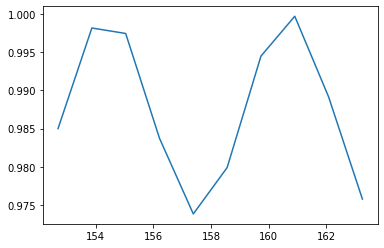

In [30]:
nf_add = np.arange(1,100,10)
parameters = list(
    product([N0], nf_add, [wL], [wh], [theta]))
results = parmap.starmap(protect_carbon,
                          parameters,
                          pm_pbar=True,
                          pm_chunksize=3)

results = np.array(results)
plt.plot(results[:,0], results[:,1])
plt.show()